# Significance Testing

This demo shows how to handle significance testing from a functional perspective of ``climpred``. In the future, we will have a robust significance testing framework inplemented with ``HindcastEnsemble`` and ``PerfectModelEnsemble`` objects.

In [3]:
import xarray as xr
from climpred.tutorial import load_dataset
from climpred import HindcastEnsemble
from climpred.stats import rm_poly
from climpred.prediction import compute_hindcast, compute_perfect_model
from climpred.bootstrap import bootstrap_hindcast, bootstrap_perfect_model
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
# load data
v = "SST"
hind = load_dataset("CESM-DP-SST")[v]
hind.lead.attrs["units"] = "years"

hist = load_dataset("CESM-LE")[v]
hist = hist - hist.mean()

obs = load_dataset("ERSST")[v]
obs = obs - obs.mean()

In [5]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_uninitialized(hist)
hindcast = hindcast.add_observations(obs, 'ERSST')

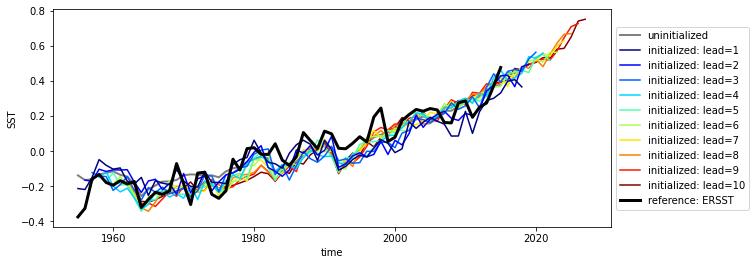

In [6]:
hindcast.plot()

Here we see the strong trend due to climate change. This trend is not linear but rather quadratic. Because we often aim to prediction natural variations and not specifically the external forcing in initialized predictions, we remove the 2nd-order trend from each dataset along a time axis.

In [7]:
order = 2
hindcast = hindcast.apply(rm_poly, dim='init', order=order).apply(rm_poly, dim='time', order=order)

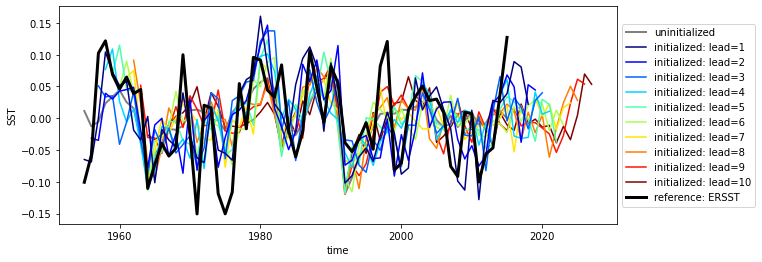

In [8]:
hindcast.plot()

## p value for temporal correlations
For correlation metrics the associated p-value checks whether the correlation 
is significantly different from zero incorporating reduced degrees of freedom 
due to temporal autocorrelation.

In [16]:
# level that initialized ensembles are significantly better than other forecast skills
sig = 0.05

In [19]:
acc = hindcast.verify(metric="pearson_r")['SST']
acc_p_value = hindcast.verify(metric="pearson_r_eff_p_value")['SST']

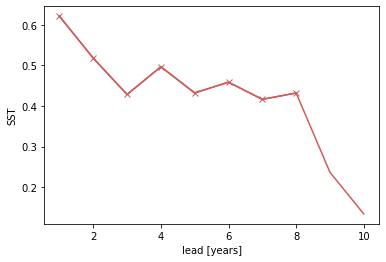

In [20]:
init_color = "indianred"
acc.plot(c=init_color)
acc.where(acc_p_value <= sig).plot(marker="x", c=init_color)

## Bootstrapping with replacement

Bootstrapping significance relies on resampling the underlying data with replacement for a large number of iterations as proposed by the decadal prediction framework of Goddard et al. 2013. We just use 20 iterations here to demonstrate the functionality.

In [26]:
hind = hindcast._datasets['initialized']['SST']
hist = hindcast._datasets['uninitialized']['SST']
obs = hindcast._datasets['observations']['ERSST']['SST']

In [27]:
%%time
bootstrapped_acc = bootstrap_hindcast(
    hind, hist, obs, metric="pearson_r", comparison="e2r", iterations=500, sig=95
)

CPU times: user 2.11 s, sys: 97.7 ms, total: 2.2 s
Wall time: 2.66 s


In [28]:
bootstrapped_acc.coords

Coordinates:
  * kind     (kind) object 'init' 'pers' 'uninit'
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
  * results  (results) <U7 'skill' 'p' 'low_ci' 'high_ci'

`bootstrap_acc` contains for the three different kinds of predictions:
- `init` for the initialized hindcast `hind` and describes skill due to initialization and external forcing
- `uninit` for the uninitialized historical `hist` and approximates skill from external forcing
- `pers` for the reference forecast computed by `baseline_compute`, which defaults to `compute_persistence`

for different results:
- `skill`: skill values
- `p`: p value
- `low_ci` and `high_ci`: high and low ends of confidence intervals based on significance threshold `sig`


In [29]:
init_skill = bootstrapped_acc.sel(results="skill", kind="init")
init_better_than_uninit = init_skill.where(
    bootstrapped_acc.sel(results="p", kind="uninit") <= sig
)
init_better_than_persistence = init_skill.where(
    bootstrapped_acc.sel(results="p", kind="pers") <= sig
)

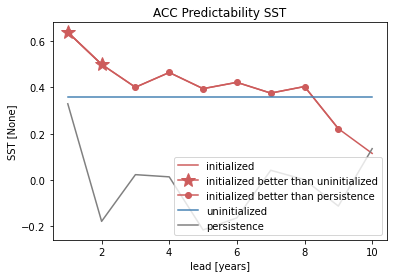

In [30]:
# create a plot by hand
bootstrapped_acc.sel(results="skill", kind="init").plot(
    c=init_color, label="initialized"
)
init_better_than_uninit.plot(
    c=init_color,
    marker="*",
    markersize=15,
    label="initialized better than uninitialized",
)
init_better_than_persistence.plot(
    c=init_color, marker="o", label="initialized better than persistence"
)
bootstrapped_acc.sel(results="skill", kind="uninit").plot(
    c="steelblue", label="uninitialized"
)
bootstrapped_acc.sel(results="skill", kind="pers").plot(c="gray", label="persistence")
plt.title(f"ACC Predictability {v}")
plt.legend(loc="lower right")

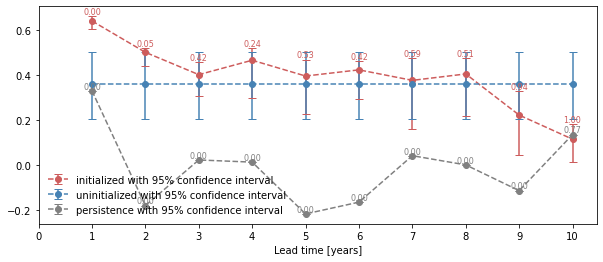

In [31]:
# use climpred convenience plotting function
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

plot_bootstrapped_skill_over_leadyear(bootstrapped_acc)

## Field significance

Using `esmtools.testing.multipletests` to control the false discovery
rate (FDR) from the above obtained p-values in geospatial data.

In [33]:
v = "tos"
ds3d = load_dataset("MPI-PM-DP-3D")[v]
ds3d.lead.attrs["unit"] = "years"
control3d = load_dataset("MPI-control-3D")[v]

In [40]:
from climpred import PerfectModelEnsemble
pm = PerfectModelEnsemble(ds3d)
pm = pm.add_control(control3d)

### p value for temporal correlations

In [42]:
acc3d = pm.compute_metric(metric='pearson_r')[v]
acc_p_3d = pm.compute_metric(metric='pearson_r_p_value')[v]

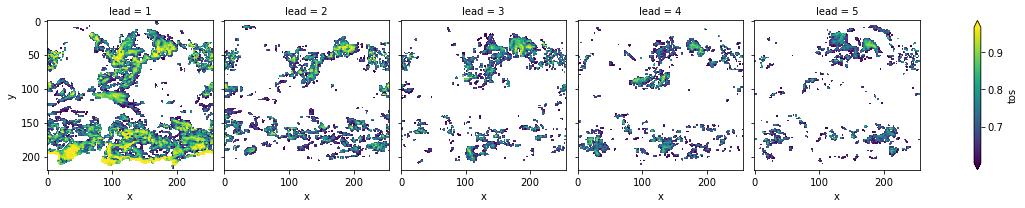

In [44]:
# mask init skill where not significant
acc3d.where(acc_p_3d <= sig).plot(col="lead", robust=True, yincrease=False,x='x')

In [45]:
# apply FDR Benjamini-Hochberg
# relies on esmtools https://github.com/bradyrx/esmtools
from esmtools.testing import multipletests

_, acc_p_3d_fdr_corr = multipletests(acc_p_3d, method="fdr_bh", alpha=sig)

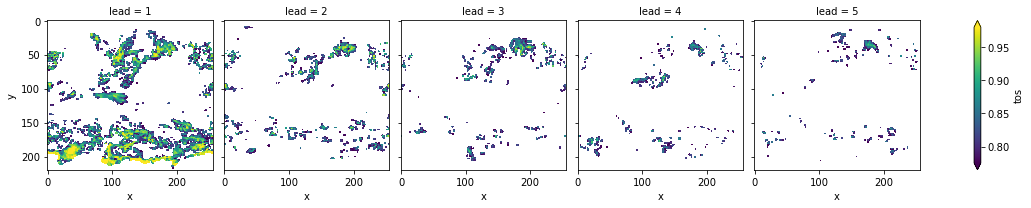

In [47]:
# mask init skill where not significant on corrected p-values
acc3d.where(acc_p_3d_fdr_corr <= sig).plot(col="lead", robust=True, yincrease=False,x='x')

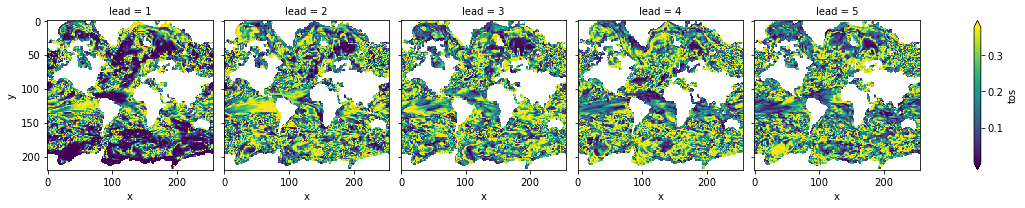

In [48]:
# difference due to FDR Benjamini-Hochberg
(acc_p_3d_fdr_corr - acc_p_3d).plot(col="lead", robust=True, yincrease=False,x='x')

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.

### Bootstrapping with replacement

In [54]:
%%time
bootstrapped_acc_3d = bootstrap_perfect_model(
    ds3d, control3d, metric="pearson_r", comparison="m2e", iterations=10
)

CPU times: user 6.26 s, sys: 4.14 s, total: 10.4 s
Wall time: 16.6 s


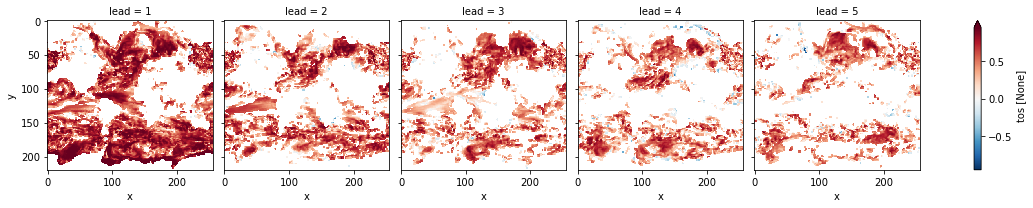

In [55]:
# mask init skill where not significant
bootstrapped_acc_3d.sel(kind="init", results="skill").where(
    bootstrapped_acc_3d.sel(kind="uninit", results="p") <= sig
).plot(col="lead", robust=True, yincrease=False)

In [56]:
# apply FDR Benjamini-Hochberg
_, bootstrapped_acc_p_3d_fdr_corr = multipletests(
    bootstrapped_acc_3d.sel(kind="uninit", results="p"), method="fdr_bh", alpha=sig
)

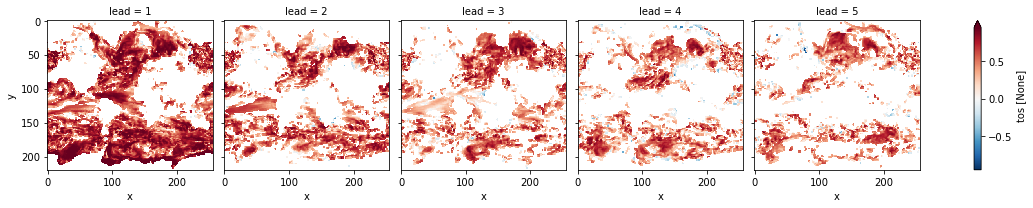

In [57]:
# mask init skill where not significant on corrected p-values
bootstrapped_acc_3d.sel(kind="init", results="skill").where(
    bootstrapped_acc_p_3d_fdr_corr <= sig*2
).plot(col="lead", robust=True, yincrease=False)

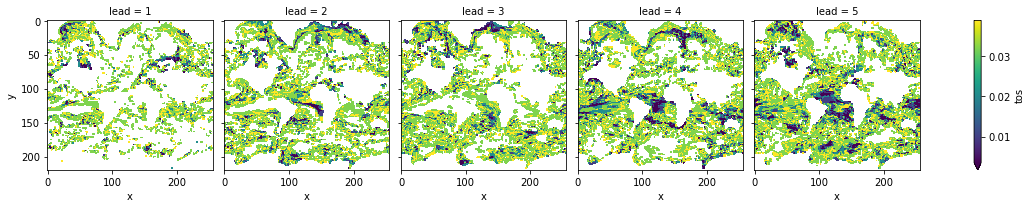

In [59]:
# difference due to FDR Benjamini-Hochberg
(
    bootstrapped_acc_p_3d_fdr_corr - bootstrapped_acc_3d.sel(kind="uninit", results="p").where(bootstrapped_acc_3d.sel(kind="uninit", results="p"))
).plot(col="lead", robust=True, yincrease=False)

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.